# Credit scoring  

SVM
(rbf, logistic)

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime
import calendar

from code_source.dataset import Dataset
from code_source.exploration.plots import *
from code_source.exploration.dates import DateContainer

pd.options.mode.chained_assignment = None

# 1. Problem statement 
In this section you should describe the business problem, that you are trying to solve.  
Predict who will pay loan.

### Objective  
Predict customers, who will default on a loan. 

### Business variables  
For business model evaluation consider using the following information:  
<b>Loan application fee (paid only, when disbursed)</b>: 5% of Amount   
<b>Annual interest rate</b>: 13%   

When loan defaults, bank loses entire loaned amount. 

Dataset contains Credit rating bureau score for the customer. This score is benchmark, that need to improve with additional data provided.  


# 2. Dataset description
Describe the dataset you are working with.  

Dataset contains a sample of **one month loans**.  
Every row in the table is one loan, issued for one month.

In [2]:
df=Dataset.get_data()

Row count: **{{len(df.index)}}**  
Column count: **{{len(df.columns)}}**  
**'Default'** is a dependent column that I have to to predict  

|Column | Data Type |NaN value count|Description | Comment|
|:-----|:---------|--------|---|---|  
| Customer_WID | {{str(df.Customer_WID.dtypes)}} |{{df.Customer_WID.isna().sum()}} |Unique customer identifier |  |
| DisbursementDate | {{str(df.DisbursementDate.dtypes)}} |{{df.DisbursementDate.isna().sum()}}| Date, when loan was disbursed  |Object type was changed to datetime in the code|
| Age | {{str(df.Age.dtypes)}} | {{df.Age.isna().sum()}}| Customer age  ||
| CustomerType | {{str(df.CustomerType.dtypes)}} | {{df.Age.isna().sum()}}|Internal customer type classification (1,2)||  
| SOR | {{str(df.SOR.dtypes)}} | {{df.SOR.isna().sum()}}|A metric of customer relationship with the bank ||   
| MonthsSinceOpen | {{str(df.MonthsSinceOpen.dtypes)}} | {{df.MonthsSinceOpen.isna().sum()}}|Number of months since first account for the customer  ||
| MonthsSinceActive | {{str(df.MonthsSinceActive.dtypes)}} | {{df.MonthsSinceActive.isna().sum()}}|Number of months since last activity || 
| FinancialMeasure1 | {{str(df.FinancialMeasure1.dtypes)}} |{{df.FinancialMeasure1.isna().sum()}}| Some measure of financial activity of a customer  ||
| FinancialMeasure2 | {{str(df.FinancialMeasure2.dtypes)}} | {{df.FinancialMeasure2.isna().sum()}}|Some measure of financial activity of a customer  ||
| FinancialMeasure3 | {{str(df.FinancialMeasure3.dtypes)}} |{{df.FinancialMeasure3.isna().sum()}}| Some measure of financial activity of a customer ||
| FinancialMeasure4 | {{str(df.FinancialMeasure4.dtypes)}} | {{df.FinancialMeasure4.isna().sum()}}|Some measure of financial activity of a customer  ||
| CRBScore | {{str(df.CRBScore.dtypes)}} | {{df.CRBScore.isna().sum()}}|Credit rating bureau score  
| Amount | {{str(df.Amount.dtypes)}} |{{df.Amount.isna().sum()}}| Loan amount || 
| **Default** | {{str(df.Default.dtypes)}} |{{df.Default.isna().sum()}}| 1 - Defaulted on this loan, 0 - paid||

# 3. Data exploration 
A free form section, where you are expected to explore the dataset and try to understand field interactions. Try seeing if fields correlate, if there is a date column how some measures change with time and what can you say about it. Try to slice your dependent variable across different independent variable. Treat outliers.

Count loans per person  
Destribution person and loans  
Plot loans per day  
Customer type and age  
boxplot per age  



### <font color=red>Tell about df.DisbursementDate=pd.to_datetime(df.DisbursementDate) in code</font>

## 3.1. Age

In [3]:
df=df.dropna()

### 3.1.1 Loan count by age

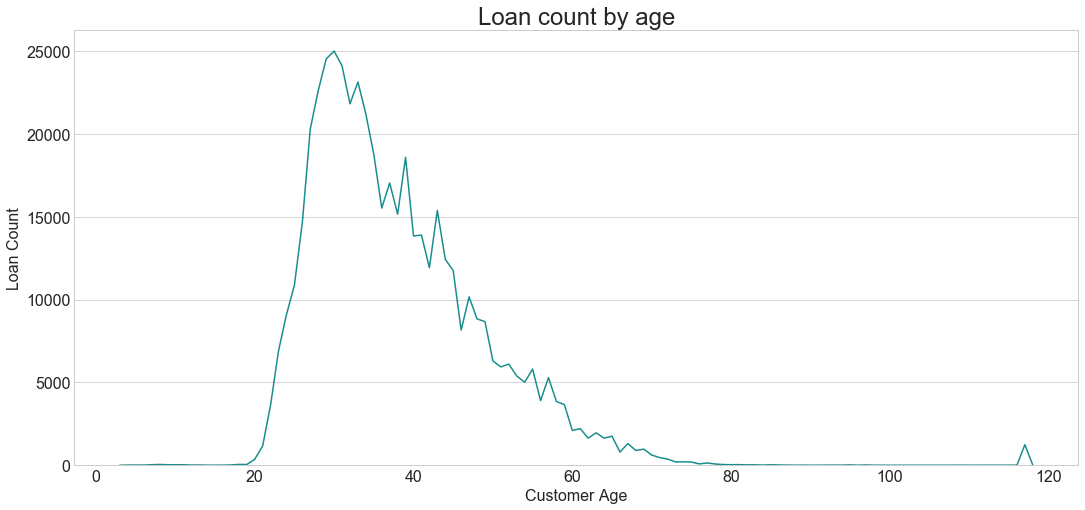

In [4]:
lineplot( df.groupby('Age')['Customer_WID'].count(),
               'Loan count by age', 
               'Customer Age', 
               'Loan Count'
        )

In [5]:
age_less18_pct=round(df[df.Age<18]['Customer_WID'].count()\
                 /df['Customer_WID'].count()*100,3)
age_more80_pct=round(df[(df.Age>80)&(df.Age<117)]['Customer_WID']\
                .count()/df['Customer_WID'].count()*100,3)
age_117_pct=round(df[df.Age==117]['Customer_WID'].count() \
              /df['Customer_WID'].count()*100,3)
age_118_count=df[df.Age==118]['Customer_WID'].count()
age_18_80=df[(df.Age>=18)&(df.Age<=80)]

The youngest customer is **{{int(df.Age.min())}}** years old  
The eldest customer is **{{int(df.Age.max())}}** years old  

The avarege customer age is **{{round(df.Age.mean())}}**.  
Age median is **{{round(df.Age.median())}}**.  
Age mode is **{{int(df.Age.mode())}}**, it means that the most customers take loans at 30 years.  
Age standard deviation is **{{round(df.Age.std(),3)}}**

**{{age_less18_pct}}%** customers are younger than 18 years,  in my analysis, I will suppose that loan can get a person who is at least 18 years old.  
 
**{{age_more80_pct}}%** customers are between 80 years and 117 years, also {{age_118_count}} customers are 118 years old. I am not sure that those data are valid and the amount is small so I will not take those data to amount when I do age binning.   

**{{age_117_pct}}%** is  117 years old. If a person born in 1900 and a loan was taken in 2017, customer can be 117 years old, but I admit that is the earliest year that can be chosen and it  has been put as default.  

I will remove rows where custumer age less than 18 and more than 80 from the dataset in the Feature engineering section because those data are not trustable. Age standard deviation will be changed from **{{round(df.Age.std(),3)}}** to **{{round(age_18_80.Age.std(),3)}}**

### 3.1.2. Average loan amount by age

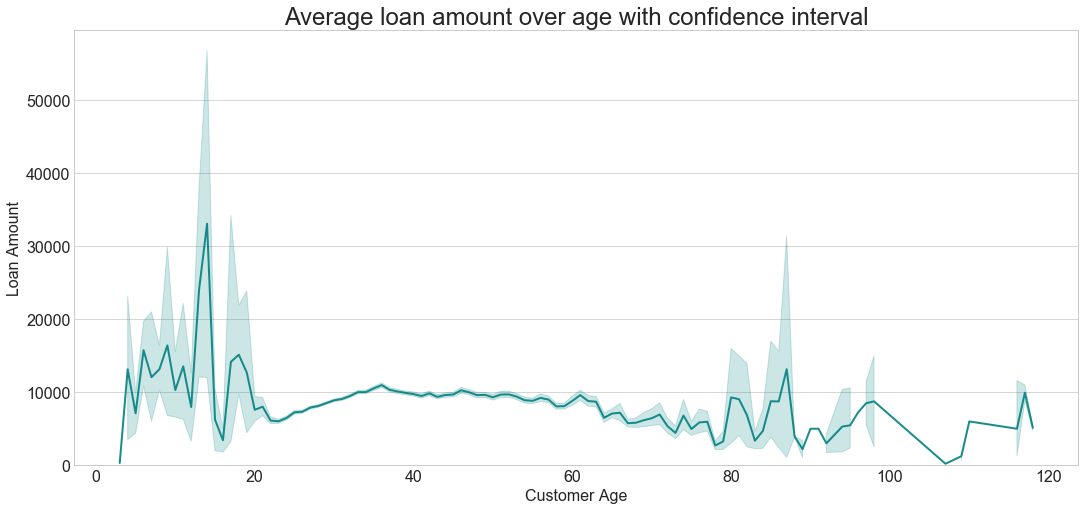

In [6]:
lineplot(df, 
         'Average loan amount over age with confidence interval', 
         'Customer Age', 
         'Loan Amount', 
          x='Age', 
          y='Amount', 
          )

The line plot with error bands showing a confidence interval. For customer between 20 and 80 years errors a much smaller, than for customer who younger than 20 or elder than 80.

## 3.2. Disbursement Date

Loan Disbursement Dates in dataset starts at **{{DateContainer.min_month}} {{DateContainer.year}}** ends at **{{DateContainer.max_month}} {{DateContainer.year}}**, a period is equal to **{{DateContainer.month_day_count.months}}** months and **{{DateContainer.month_day_count.days}}** days

### 3.2.1 Loan count per customer

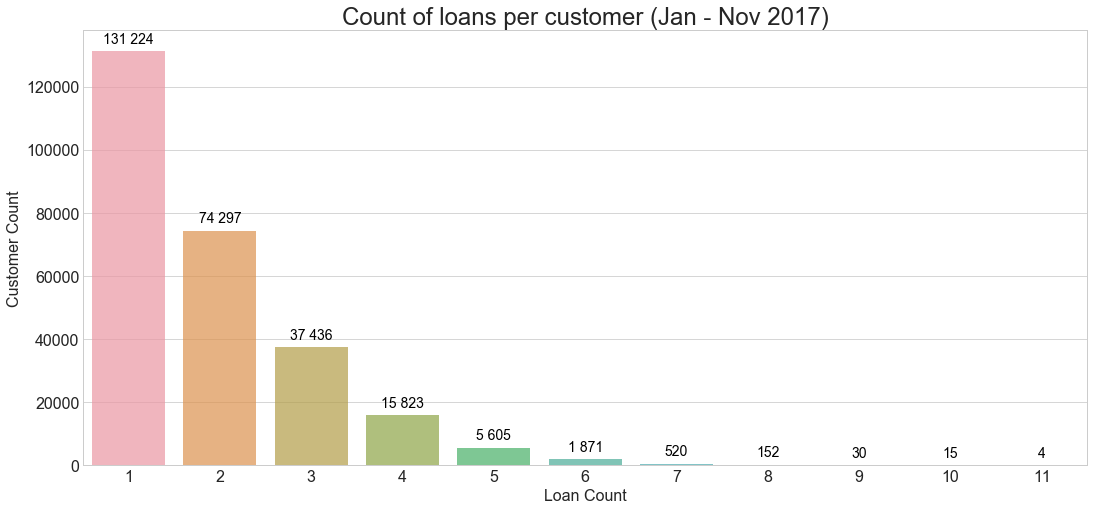

In [7]:
tmp = df.groupby('Customer_WID')["Customer_WID"].count().reset_index(name="LoanCount").\
groupby("LoanCount").count().reset_index().rename(columns={"Customer_WID": "CustomerCount"})
title='Count of loans per customer (%s - %s %s)' %(DateContainer.min_month_abbr,
        DateContainer.max_month_abbr, DateContainer.year)
barplot(tmp, 'LoanCount', 'CustomerCount', title, 'Loan Count', 'Customer Count')

### 3.2.2 Loan count per month

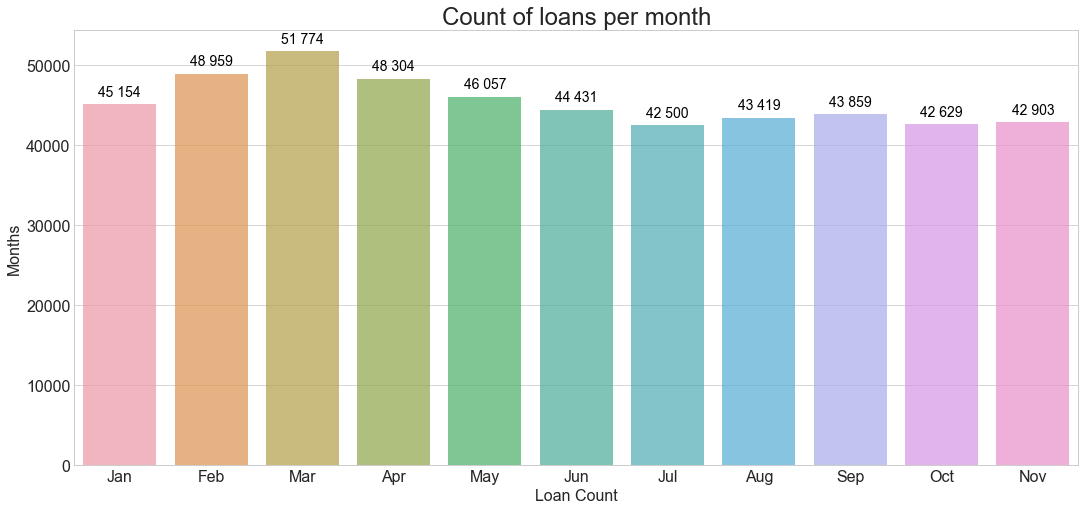

In [8]:
tmp=df.groupby(df['DisbursementDate'].dt.month)['Customer_WID']. \
        count().reset_index(name="LoanCount").sort_values('DisbursementDate')
for i in range(len(tmp.DisbursementDate)):
    tmp.DisbursementDate[i]=calendar.month_abbr[i+1]
title='Count of loans per month'
barplot(tmp, 'DisbursementDate','LoanCount', title, 'Loan Count', 'Months')

### 3.2.2 Loan count and amount per day

 


Min loan count in one day: **{{round(df.groupby(df.DisbursementDate).Customer_WID.count().min())}}**  
Max loan count in one day: **{{round(df.groupby(df.DisbursementDate).Customer_WID.count().max())}}**  
Avarege loan count in one day: **{{round(df.groupby(df.DisbursementDate).Customer_WID.count().mean())}}**  

Min loan amount in one day: **{{int(df.groupby(df.DisbursementDate).Amount.sum().min())}}**  
Max loan amount in one day: **{{int(df.groupby(df.DisbursementDate).Amount.sum().max())}}**  
Avarege loan amount in one day: **{{round(df.groupby(df.DisbursementDate).Amount.sum().mean())}}**  

### 3.2.3 Loan amount per month

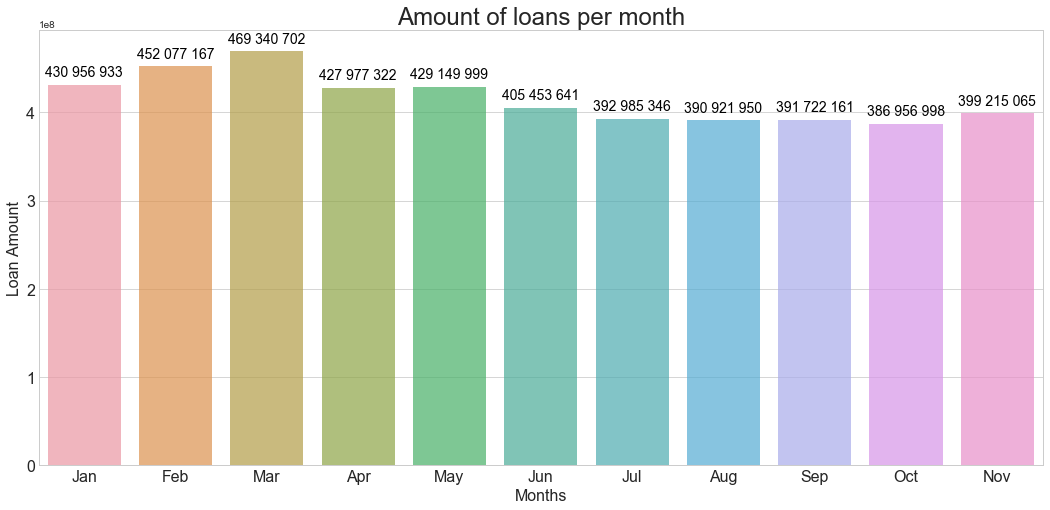

In [9]:
tmp=df.groupby(df['DisbursementDate'].dt.month)['Amount']. \
        sum().reset_index(name="LoanAmount").sort_values('DisbursementDate')
for i in range(len(tmp.DisbursementDate)):
    tmp.DisbursementDate[i]=calendar.month_abbr[i+1]  
barplot(tmp, 'DisbursementDate','LoanAmount', 'Amount of loans per month', 'Months', 'Loan Amount')

## 3.3. Customer Type

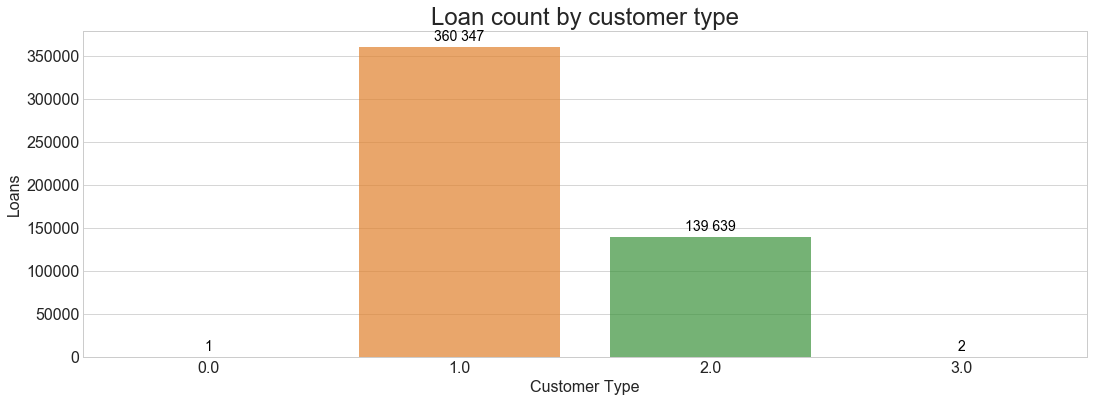

In [10]:
tmp = df.groupby("CustomerType").count().reset_index()
barplot(tmp, 'CustomerType', 'Customer_WID', 'Loan count by customer type', \
        'Customer Type', 'Loans', figsize=(18,6))

Internal customer type classification contains two types: '1', '2', but dataset also have 2 customer with type '3' and one customer with type '0'.  
I will delete those 3 rows from the dataset in the Feature engineering section.

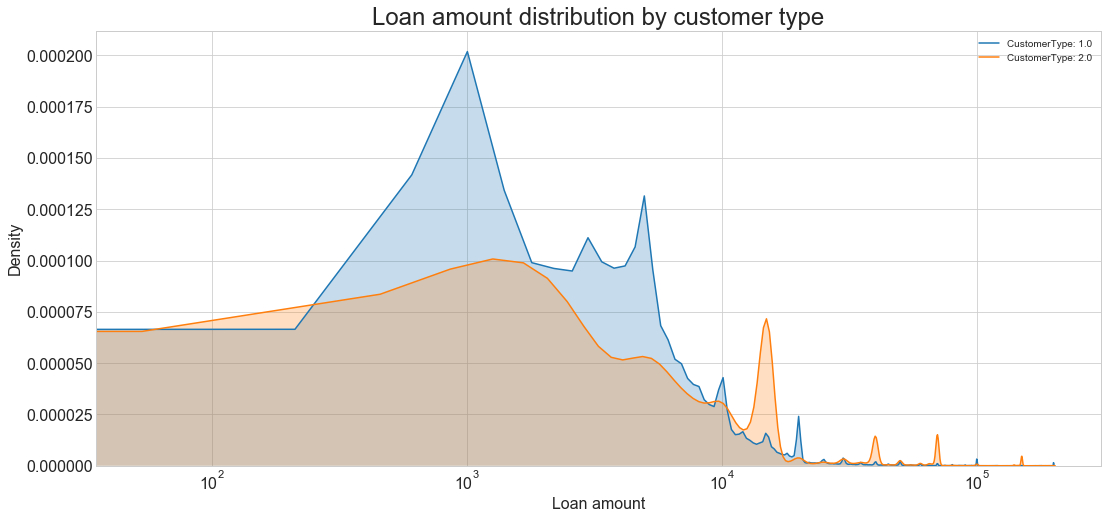

In [11]:
densityplot(df[df.CustomerType.isin([1, 2])], "Amount", 'CustomerType', 
        'Loan amount distribution by customer type', 
        'Loan amount', 'Density')

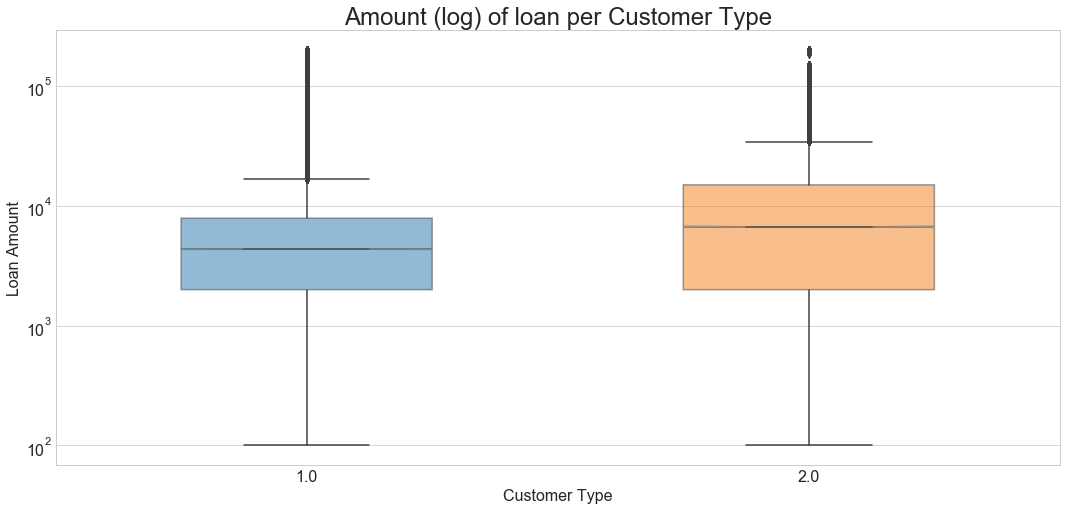

In [12]:
boxplot(df[df.CustomerType.isin([1, 2])], 'CustomerType', 'Amount', 'Amount (log) of loan per Customer Type', \
        'Customer Type', 'Loan Amount', yscale="log")

## 3.N. Default

In [13]:
mapping={
    0 : 'Loan paid',
    1 : 'Loan defaulted'
    }
tmp=[df]
for d in tmp:
    d['DefaultLabel']=d.Default.map(mapping)

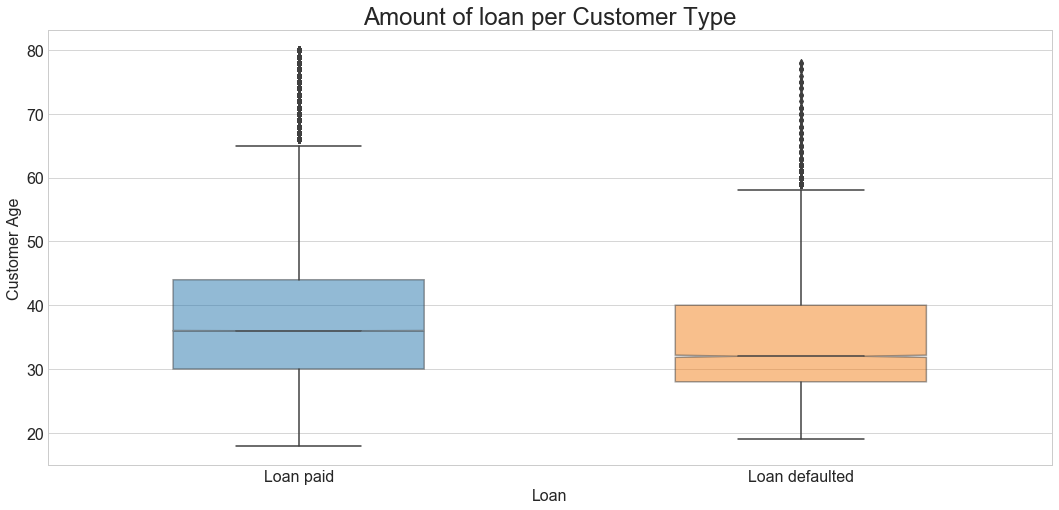

In [14]:
tmp=df[(df.Age>=18)&(df.Age<=80)]
boxplot(tmp, 'DefaultLabel', 'Age', 'Amount of loan per Customer Type', \
        'Loan', 'Customer Age')

In [16]:
tmp = df[df.CustomerType.isin([1, 2])]

,Customer_WID,DisbursementDate,Age,CustomerType,SOR,MonthsSinceOpen,MonthsSinceActive,FinancialMeasure1,FinancialMeasure2,FinancialMeasure3,FinancialMeasure4,CRBScore,Amount,Default,DefaultLabel
0,380415,2017-10-13,27.0,1.0,3.0,53.0,0.0,0.0,25.85,7308.66,8885.00,547.0,1000.0,0,Loan paid
1,153249,2017-09-06,54.0,1.0,3.0,142.0,0.0,0.0,12.05,6268.00,3807.00,506.0,2050.0,0,Loan paid
2,82776,2017-09-25,44.0,2.0,5.0,70.0,0.0,0.0,369.04,15475.66,13883.00,554.0,500.0,0,Loan paid
3,190996,2017-06-23,30.0,1.0,5.0,93.0,0.0,0.0,403.01,13294.33,13481.00,569.0,200.0,0,Loan paid
4,375566,2017-08-23,36.0,1.0,5.0,116.0,0.0,39678.0,2143.38,20054.76,19227.40,633.0,7000.0,0,Loan paid
5,381960,2017-04-05,30.0,2.0,5.0,101.0,0.0,0.0,14666.74,30720.00,31140.00,524.0,12000.0,0,Loan paid
6,134107,2017-02-04,27.0,1.0,5.0,62.0,0.0,62180.0,22324.47,67539.24,52725.60,704.0,7750.0,0,Loan paid
7,105666,2017-05-06,36.0,1.0,5.0,84.0,0.0,37815.0,7818.25,19475.43,12263.10,690.0,10000.0,0,Loan paid
8,357649,2017-01-16,58.0,2.0,5.0,60.0,0.0,0.0,30309.74,79240.00,14500.00,715.0,7000.0,0,Loan paid
9,54884,2017-06-29,67.0,1.0,4.0,138.0,0.0,0.0,1233.72,12096.66,18200.00,567.0,2100.0,0,Loan paid


In [ ]:
tmp = df[df.CustomerType.isin([1, 2])]
barplot(tmp, 'DefaultLabel', 'CustomerType', 'Loan count by customer type', \
        'Customer Type', 'Loans', figsize=(18,6))
# data, x, y, title, xlabel, ylabel, figsize=(18, 8),

In [ ]:
df.Default.value_counts()

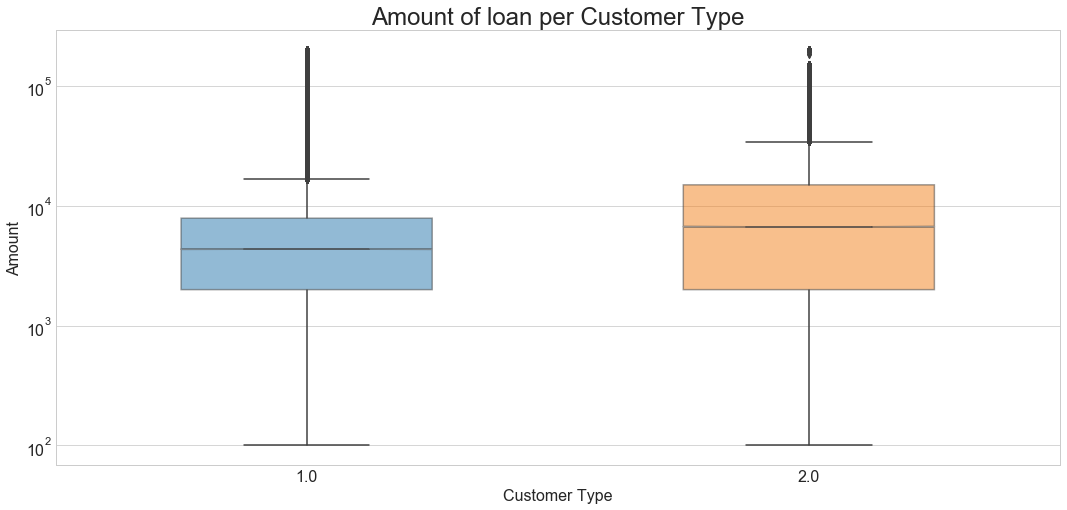

In [15]:
boxplot(df[df.CustomerType.isin([1, 2])], 'CustomerType', 'Amount', 'Amount of loan per Customer Type', \
        'Customer Type', 'Amount', yscale="log")

0. Average credit rating over age, financial measures 1
1. % of Default over age
2. % of Default over customer type
3. % of Default over credit rating

# 4. Feature engineering 
Describe and show code that transforms your original dataset into dataset ready for prediction.

### <font color=red>Since you have customer identifier and date, when loan was issued you can try to build additional features based on previous loans.</font>

## 4.1. Remove NaN values

In [ ]:
df=df.dropna()

## 4.2. Quantize age

In [ ]:
import numpy as np
q = np.linspace(0, 1, 21)
np.quantile(df.Age, q)

# 5. Feature selection 
Describe how you approached feature selection: which features you decided to include in your models and why.

# 6. Modeling 
Describe different binary classification models you used for this project. Ensure that you are correctly splitting dataset into train and test.
Model evaluation - describe which metrics you used for model comparison and why. Compare models fit in step 6 using technical and business measures (potential revenue lift from using one model instead of another, refer to Business variables section).
Recommendation - a small section, where you recommend one of the models built in section 6 and 7 for utilization in production. Make sure to describe why using business evaluation terms.
Conclusion - final conclusions. Describe your thoughts about the project, is it worth to put resulting model in production, what additional data could benefit your model.

<font color=red>
For credit scoring it is crucially important to start of with model, that is explainable and robust to outliers. Then you might want to investigate more complicated models, and provide a tradeof between explainability and predictive power.   

At the end you need to provide estimated monthly revenue by using your credit scoring model (refer to business variables above) and what is the cutoff for loan acceptance.</font>

# 7. Model evaluation 
Describe which metrics you used for model comparison and why. Compare models fit in step 6 using technical and business measures (potential revenue lift from using one model instead of another, refer to Business variables section).
Recommendation - a small section, where you recommend one of the models built in section 6 and 7 for utilization in production. Make sure to describe why using business evaluation terms.
Conclusion - final conclusions. Describe your thoughts about the project, is it worth to put resulting model in production, what additional data could benefit your model.

# 8. Recommendation 
A small section, where you recommend one of the models built in section 6 and 7 for utilization in production. Make sure to describe why using business evaluation terms.
Conclusion - final conclusions. Describe your thoughts about the project, is it worth to put resulting model in production, what additional data could benefit your model.

# 9. Conclusion 
Final conclusions. Describe your thoughts about the project, is it worth to put resulting model in production, what additional data could benefit your model.